# Welcome to the cooltools pileups notebook!

TODO: Add introduction on Hi-C averaging, which is a common analysis tool. Pileup plot is one of these amazing techniques. 

Content:

- Data download
- Loading genomic regions
- On-diagonal pipeup of CTCF
- Off-diagonal pileup of CTCF

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# import libraries for biological data analysis
import cooler
import bioframe

import cooltools
from cooltools import snipping
import cooltools.expected

### Data download

TODO: Add more information on the datasets; call types; ChIP-Seq and Hi-C; emphasize what the data are & how it was created

In [3]:
# Print available datasets for download
cooltools.print_available_datasets()

Available datasets:
1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
  Downloaded from https://osf.io/3h9js/download 
  Stored as test.mcool
2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
  Downloaded from https://osf.io/w92u3/download 
  Stored as test_CTCF.bigWig
3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
  Downloaded from https://osf.io/c9pwe/download 
  Stored as test_CTCF.bed.gz


In [4]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')

### Loading genomic regions

When constructing an average plot, the pileup function needs **genomic regions**. 

The purpose of loading the regions: 

- First, the pileup uses regions for parallelization of snipping. Different genomic regions are loaded simultaneously by different processes, and the snipping can be done in parallel. 
- Second, one particular type of pileup, observed over expected pileup, requires calculating expected interactions before snipping (P(s), in other words). Typically, you want to calculate P(s) for each chromosome arm separately and not to include the interactions between chromosome arms. Inter-arms interactions might be affected by strong insulation of centromeres or Rabl configuration). 

For species that do not have information on chromosome arms, or have telocentric chromosomes (e.g., mouse), you may want to use full chromosomes instead. 

In [5]:
# Open cool file with Micro-C data:
clr = cooler.Cooler('./test.mcool::/resolutions/1000')
# Set up selected data resolution:
resolution = 1000

In [6]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_chromsizes = hg38_chromsizes.set_index("chrom").loc[clr.chromnames].reset_index() 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.parse_regions(hg38_arms)

### Reading features for pileups

As input for the pileup you need genomic **features** that will be used for centering the **snippets**. You will use positions of CTCF motifs in the peaks as features. 

In [7]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf.head()

,chrom,start,end,name,score,strand
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-


In [8]:
# select the top 500 CTCF sites by the strength of binding
sites = ctcf.sort_values('score', ascending=False).iloc[:500]
sites.head()

,chrom,start,end,name,score,strand
25503,chr2,231612720,231612739,MA0139.1_CTCF_human,17.565931,+
19151,chr17,75905145,75905164,MA0139.1_CTCF_human,17.527591,+
19048,chr17,73370058,73370077,MA0139.1_CTCF_human,17.520560,-
17845,chr17,27760209,27760228,MA0139.1_CTCF_human,17.448366,+
17408,chr17,4413369,4413388,MA0139.1_CTCF_human,17.382937,-


Let's take a look at the distribution of scores and the top 500 selected ones: 

Text(0.5, 1.0, 'Histogram of CTCF motifs scores')

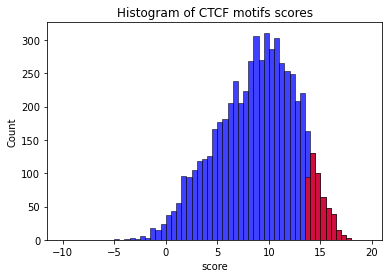

In [9]:
# TODO: Add CTCF peak prominence from MACS output instead (or mean score of 100-bp extended regions)
# TODO: Xisualize the correlation between motif score and peak prominence
sns.histplot(ctcf.score, color='blue', bins=np.arange(-10,20,0.5))
sns.histplot(sites.score, color='red', bins=np.arange(-10,20,0.5))
plt.title('Histogram of CTCF motifs scores')

## On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. cooltools will create a snippet of Hi-C map for each feature. Then you can combine them into a single 2D pileup. 

In [10]:
# Converting dataframe with features to format digestible by cooltools
# This will be changed in the future and substituted with nicer API
flank = 100000
windows = snipping.make_bin_aligned_windows(
    resolution, 
    sites['chrom'], 
    (sites['start'] + sites['end'])//2,
    flank_bp=flank)
windows['strand'] = sites['strand']

# Assign genomic regions to windows:
supports = hg38_arms[['chrom', 'start', 'end']].values
windows = snipping.assign_regions(windows, supports)
windows.head()
# TODO: add bioframe cluster at this step to get rid of too-close-CTCFs

,chrom,start,end,lo,hi,strand,region
25503,chr2,231512000,231713000,231512,231713,+,chr2:93139351-242193529
19151,chr17,75805000,76006000,75805,76006,+,chr17:24714921-83257441
19048,chr17,73270000,73471000,73270,73471,-,chr17:24714921-83257441
17845,chr17,27660000,27861000,27660,27861,+,chr17:24714921-83257441
17408,chr17,4313000,4514000,4313,4514,-,chr17:0-24714921


#### On-diagonal pileup of ICed Hi-C interactions

In [11]:
# create the snipper object, which can be re-defined by user. 
# this will be changed in future
snipper = cooltools.snipping.CoolerSnipper(clr)

stack = cooltools.snipping.pileup(
        windows, 
        snipper.select, 
        snipper.snip) 

# mirror reflect snippets whose feature is on the opposite strand
mask = np.array(windows.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]

# note that we use nanmean: some pixels might be converted to NaNs after IC
mtx = np.nanmean(stack, axis=2)

In [12]:
# load the fall colormap
import cooltools.lib.plotting

Text(0, 0.5, 'relative position, kbp')

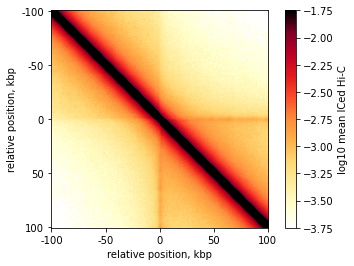

In [13]:
plt.imshow(
    np.log10(mtx),
    vmax = -3.75,
    vmin = -1.75,
    cmap='fall')
plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

#### On-diagonal pileup of observed over expected interactions

Sometimes you don't want to include the **distance decay** P(s) in your pileups. For example, when you make comparison of pileups between experiments and they have different P(s). Even if these differences are sight, they might affect the pileup of raw ICed Hi-C interactions. 

In this case, the observed over expected pileup is your choice. Prior to running the pileup function, you need to calculate expected interactions for chromosome arms. This step might be time-consuming, thus you may use the **parallelization** for this step. 

In [14]:
# Setting up parallelization
import multiprocess
nthreads = 4

In [15]:
# calculate expected interactions for chromosome arms
clr = cooler.Cooler('./test.mcool::/resolutions/1000')     

with multiprocess.Pool(nthreads) as pool:
    expected = cooltools.expected.diagsum(
        clr, 
        regions=hg38_arms, 
        transforms={
            'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
        },
    map=pool.map
    )
    
# add annotation of chromosome arms to the dataframe, this won't be needed in the future versions of cooltools
expected = pd.concat([expected, bioframe.region.parse_regions(expected.region)], axis=1).drop('name', axis=1)

# calculate average number of interactions per diagonal, this won't be needed in the future versions of cooltools
expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']

In [16]:
oe_snipper = cooltools.snipping.ObsExpSnipper(clr, expected)

# create the stack of snips:
with multiprocess.Pool(nthreads) as pool:
    stack = cooltools.snipping.pileup(
            windows, 
            oe_snipper.select, 
            oe_snipper.snip,
            map=pool.map
            ) 

# mirror reflect snippets whose feature is on the opposite strand
mask = np.array(windows.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]
    
mtx = np.nanmean(stack, axis=2)

<ipython-input-16-aa67472fe70b>:16: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=2)


Text(0, 0.5, 'relative position, kbp')

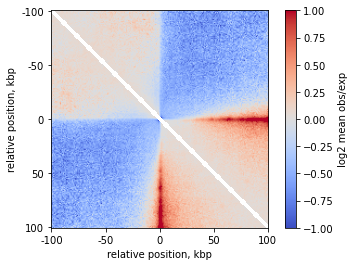

In [17]:
plt.imshow(
    np.log2(mtx),
    vmax = 1.0,
    vmin = -1.0,
    cmap='coolwarm')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

#### Inspect the snips

TODO: Add the idea of sorting and making sense of it.

TODO: Add idea on the outliers that might affect individual snips and the whole pileup

In [18]:
from ipywidgets import interact
from matplotlib.gridspec import GridSpec

n_examples = len(windows)

@interact(i=(0, n_examples-1))
def f(i):
    fig, ax = plt.subplots(figsize=[5,5])
    img = ax.matshow(
        np.log2(stack[:, :, i]),  
        vmin=-1,
        vmax=1,
        extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
        cmap='coolwarm'
    )
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title('')
    plt.axvline(0, c='g', ls=':')
    plt.axhline(0, c='g', ls=':')

interactive(children=(IntSlider(value=249, description='i', max=499), Output()), _dom_classes=('widget-interac…

In [19]:
# TODO: Add the grouping of quantiles by CTCF strength and four average maps.
# TODO: Add idea that windows and snips can be reused

## Off-diagonal pileup

**Off-diagonal pileups** are the averaged Hi-C maps around double anchors. In this case, the anchors are CTCF sites in the genome. 

In [20]:
sites = ctcf.sort_values('score', ascending=False).iloc[:5000] # TODO: check and change 
sites.head()

,chrom,start,end,name,score,strand
25503,chr2,231612720,231612739,MA0139.1_CTCF_human,17.565931,+
19151,chr17,75905145,75905164,MA0139.1_CTCF_human,17.527591,+
19048,chr17,73370058,73370077,MA0139.1_CTCF_human,17.520560,-
17845,chr17,27760209,27760228,MA0139.1_CTCF_human,17.448366,+
17408,chr17,4413369,4413388,MA0139.1_CTCF_human,17.382937,-


In [21]:
len(sites)

5000

In [22]:
# TODO: This will be replaced by appropriate bioframe function
# Create the dataframe of paired anchors

max_shift = 100
min_dist = 20000
max_dist = 1000000

sites_paired = pd.DataFrame()
for i in range(1, max_shift):
    partial_sites_paired = pd.merge( sites, sites.shift(i), left_index=True, right_index=True, suffixes=['1', '2'] )\
        .query('chrom1==chrom2')\
        .query(f'abs(start2-start1)>{min_dist} and abs(start2-start1)<{max_dist}')\
        .query('strand1=="+" and strand2=="-"')
    partial_sites_paired = partial_sites_paired[['chrom1', 'chrom2', 'start1', 'end1', 'start2', 'end2']]

    sites_paired = pd.concat([sites_paired, partial_sites_paired], axis=0).reset_index(drop=True)
    
sites_paired.loc[:, 'mid1'] = (sites_paired['start1'] + sites_paired['end1'])//2
sites_paired.loc[:, 'mid2'] = (sites_paired['start2'] + sites_paired['end2'])//2

In [23]:
print(len(sites_paired))
sites_paired.head()

992


,chrom1,chrom2,start1,end1,start2,end2,mid1,mid2
0,chr2,chr2,219997418,219997437,219295008.0,219295027.0,219997427,219295017.0
1,chr2,chr2,97591009,97591028,97112423.0,97112442.0,97591018,97112432.0
2,chr17,chr17,47500787,47500806,48374830.0,48374849.0,47500796,48374839.0
3,chr17,chr17,61002449,61002468,60037265.0,60037284.0,61002458,60037274.0
4,chr17,chr17,28712453,28712472,29112007.0,29112026.0,28712462,29112016.0


In [24]:
flank = 100000

windows1 = snipping.make_bin_aligned_windows(
    resolution, 
    sites_paired['chrom1'], 
    sites_paired['mid1'],
    flank_bp=flank)

windows2 = snipping.make_bin_aligned_windows(
    resolution, 
    sites_paired['chrom2'], 
    sites_paired['mid2'],
    flank_bp=flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)

In [25]:
windows.head()

,chrom1,start1,end1,lo1,hi1,chrom2,start2,end2,lo2,hi2,region
0,chr2,219897000,220098000,219897,220098,chr2,219195000,219396000,219195,219396,chr2:93139351-242193529
1,chr2,97491000,97692000,97491,97692,chr2,97012000,97213000,97012,97213,chr2:93139351-242193529
2,chr17,47400000,47601000,47400,47601,chr17,48274000,48475000,48274,48475,chr17:24714921-83257441
3,chr17,60902000,61103000,60902,61103,chr17,59937000,60138000,59937,60138,chr17:24714921-83257441
4,chr17,28612000,28813000,28612,28813,chr17,29012000,29213000,29012,29213,chr17:24714921-83257441


In [26]:
# TODO: add link to the upper cell where expected is calculated

In [27]:
oe_snipper = cooltools.snipping.ObsExpSnipper(clr, expected)

# create the stack of snips:
with multiprocess.Pool(nthreads) as pool:
    stack = cooltools.snipping.pileup(
            windows, 
            oe_snipper.select, 
            oe_snipper.snip,
            map=pool.map
            ) 
    
mtx = np.nanmean(stack, axis=2)

Text(0, 0.5, 'relative position, kbp')

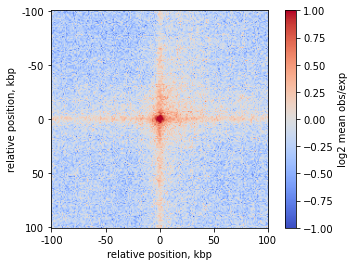

In [28]:
plt.imshow(
    np.log2(mtx),
    vmax = 1.0,
    vmin = -1.0,
    cmap='coolwarm')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')